In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import math

In [114]:
# Load in the data
data_day = pd.read_csv('day.csv')
data_hour = pd.read_csv('hour.csv')

In [115]:
# Set what evening means
evening_hrs = np.arange(15, 23)

# set what is spring and summer
season = {'winter': 1,
          'spring': 2,
          'summer': 3,
          'autumn': 4}

In [116]:
# create df only looking at evening hours, and their respective season
data_spring_workday = data_hour[(data_hour['hr'].isin(evening_hrs)) &
                                (data_hour['season']==season['spring']) &
                                (data_hour['workingday']==1)]
data_summer_workday = data_hour[(data_hour['hr'].isin(evening_hrs)) &
                                (data_hour['season']==season['summer']) &
                                (data_hour['workingday']==1)]

# now summarise the data so each line in data represents one sample event, ie. the total number of bike hires 
# during peak commuting times on a single day
data_spring_eve_workday = data_spring_workday.groupby(['dteday', 'weekday'])[['casual', 'registered', 'cnt']].sum()
data_summer_eve_workday = data_summer_workday.groupby(['dteday', 'weekday'])[['casual', 'registered', 'cnt']].sum()

# get the weather, temp and hum info average for the evening on that day
data_spring_eve_workday_weather = data_spring_workday.groupby(['dteday', 'weekday'])[['weathersit', 'temp', 'atemp', 'weathersit', 'hum', 'windspeed']].mean()
data_summer_eve_workday_weather = data_summer_workday.groupby(['dteday', 'weekday'])[['weathersit', 'temp', 'atemp', 'weathersit', 'hum', 'windspeed']].mean()

# join average weather data to bike counts
data_spring_eve_workday = pd.concat([data_spring_eve_workday, data_spring_eve_workday_weather], axis=1)
data_summer_eve_workday = pd.concat([data_summer_eve_workday, data_summer_eve_workday_weather], axis=1)

# remove weekday and date being the index - change to just row number being index:
data_spring_eve_workday.reset_index(inplace=True)
data_summer_eve_workday.reset_index(inplace=True)

### Complete some quick checks
Check we get expected results when we compare our transformed data to the original data

In [118]:
# Quick sense check on the size of the new data sets
# number of working days in data_day should be the same as number of rows in summer_eve + spring_eve

print(f"spring shape: {data_spring_eve_workday.shape}")
print(f"summer shape: {data_summer_eve_workday.shape}")
print(f"total spring and summer working day shape: {data_day[(data_day['workingday']==True) & (data_day['season'].isin([2,3]))].shape}")



spring shape: (128, 11)
summer shape: (131, 11)
total spring and summer working day shape: (259, 16)


In [119]:
# check the average weather data for one day in summer
selected_day = '2012-07-20'
a = data_hour[(data_hour['dteday']==selected_day) &
              data_hour['hr'].isin(evening_hrs)]
b = data_summer_eve_workday[data_summer_eve_workday['dteday']==selected_day]
print("Summer day check:")
print(f"data['cnt'] = {a['cnt'].sum()}")
print(f"summer['cnt'] = {b['cnt'].sum()}")

print(f"data['weathersit'] = {a['weathersit'].mean()}")
print(f"summer['weathersit'] = {b['weathersit'].mean()}")

# check the average weather data for one day in spring
selected_day = '2012-05-15'
a = data_hour[(data_hour['dteday']==selected_day) &
              data_hour['hr'].isin(evening_hrs)]
b = data_spring_eve_workday[data_spring_eve_workday['dteday']==selected_day]

print("\nSpring day check:")
print(f"data['cnt'] = {a['cnt'].sum()}")
print(f"spring['cnt'] = {b['cnt'].sum()}")

print(f"data['weathersit'] = {a['weathersit'].mean()}")
print(f"spring['weathersit'] = {b['weathersit'].mean()}")

Summer day check:
data['cnt'] = 2899
summer['cnt'] = 2899
data['weathersit'] = 2.25
summer['weathersit'] = weathersit    2.25
weathersit    2.25
dtype: float64

Spring day check:
data['cnt'] = 3008
spring['cnt'] = 3008
data['weathersit'] = 1.625
spring['weathersit'] = weathersit    1.625
weathersit    1.625
dtype: float64


### Plot Various plots of the data ###

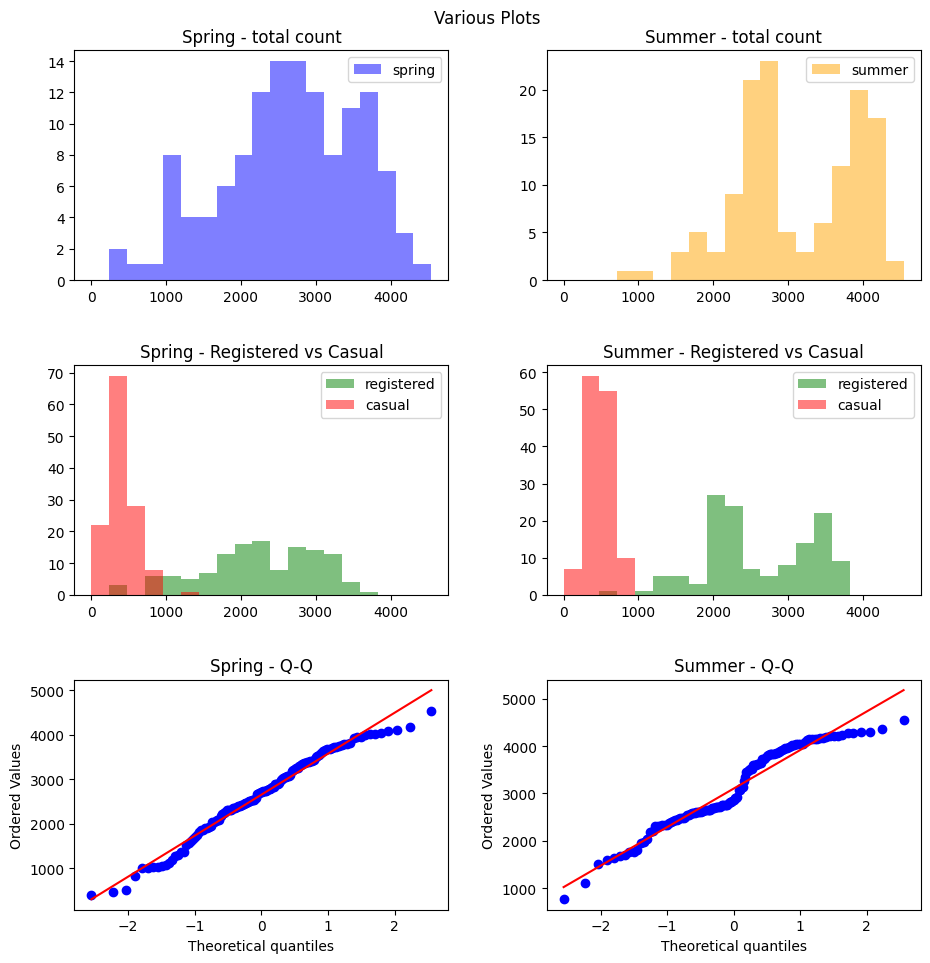

In [127]:
# setup axes
fig, axs = plt.subplots(3,2, figsize=(10,10))
fig.tight_layout(pad=4)
fig.suptitle('Various Plots')

# histogram paramaters
n_bins = 20
x_min = 0
x_max = max(data_spring_eve_workday['cnt'].max(), data_summer_eve_workday['cnt'].max())
bins = np.linspace(x_min, x_max, n_bins)

# total count spring (evening, workday)
axs[0,0].hist(x='cnt', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='blue', label='spring')
axs[0,0].legend()
axs[0,0].title.set_text('Spring - total count')

# total count summer (evening, workday)
axs[0,1].hist(x='cnt', data=data_summer_eve_workday, bins=bins, alpha=0.5, color='orange', label='summer')
axs[0,1].legend()
axs[0,1].title.set_text('Summer - total count')

#  Spring - registered users vs casual
axs[1,0].hist(x='registered', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='green', label='registered')
axs[1,0].hist(x='casual', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='red', label='casual')
axs[1,0].legend()
axs[1,0].title.set_text('Spring - Registered vs Casual')

# summer - registered users vs casual
axs[1,1].hist(x='registered', data=data_summer_eve_workday, bins=bins, alpha=0.5, color='green', label='registered')
axs[1,1].hist(x='casual', data=data_summer_eve_workday, bins=bins, alpha=0.5, color='red', label='casual')
axs[1,1].legend()
axs[1,1].title.set_text('Summer - Registered vs Casual')

# Q-Q plots against norms
stats.probplot(data_spring_eve_workday['cnt'], dist="norm", plot=axs[2,0])
axs[2,0].title.set_text("Spring - Q-Q")
stats.probplot(data_summer_eve_workday['cnt'], dist="norm", plot=axs[2,1])
axs[2,1].title.set_text("Summer - Q-Q")

In [121]:
# Imperical cdf - data is a df, x is a scaler, 
def empircal_cdf(x, data, index, col):
    sum = data.loc[data[index] <= x, col].sum()
    return sum / data[col].sum()

### Test using the Cramer-von Mises One Sample Test ###
Note this is using estimated mean, and standard deviation from the sample set which from my understanding invalidates the result
There is a version of the test that doesn't rely on estimating the mean, s.t.d. from the sample set but doesn't have a closed form distribution for the test statistic so has to be simulated. Not sure what the group think on this?

In [122]:
# Sort date in ascending order:
data_spring_eve_workday.sort_values(by=['cnt'], inplace=True)
data_summer_eve_workday.sort_values(by=['cnt'], inplace=True)

# Calculate the Cramer-von Misses test statistic
mean_spring_est = data_spring_eve_workday['cnt'].mean()
mean_summer_est = data_summer_eve_workday['cnt'].mean()

std_spring_est = data_spring_eve_workday['cnt'].std()
std_summer_est = data_summer_eve_workday['cnt'].std()

cdf_spring_est = lambda x : stats.norm.cdf(x, mean_spring_est, std_spring_est)
cdf_summer_est = lambda x : stats.norm.cdf(x, mean_summer_est, std_summer_est)

result_spring = stats.cramervonmises(data_spring_eve_workday['cnt'], cdf_spring_est)
result_summer = stats.cramervonmises(data_summer_eve_workday['cnt'], cdf_summer_est)

print(f"spring results: {result_spring}\n\n")
print(f"summer results: {result_summer}\n\n")

spring resilts: CramerVonMisesResult(statistic=0.07877307636504718, pvalue=0.6998247223205118)


summer resilts: CramerVonMisesResult(statistic=0.5349115110684625, pvalue=0.03235278072686032)




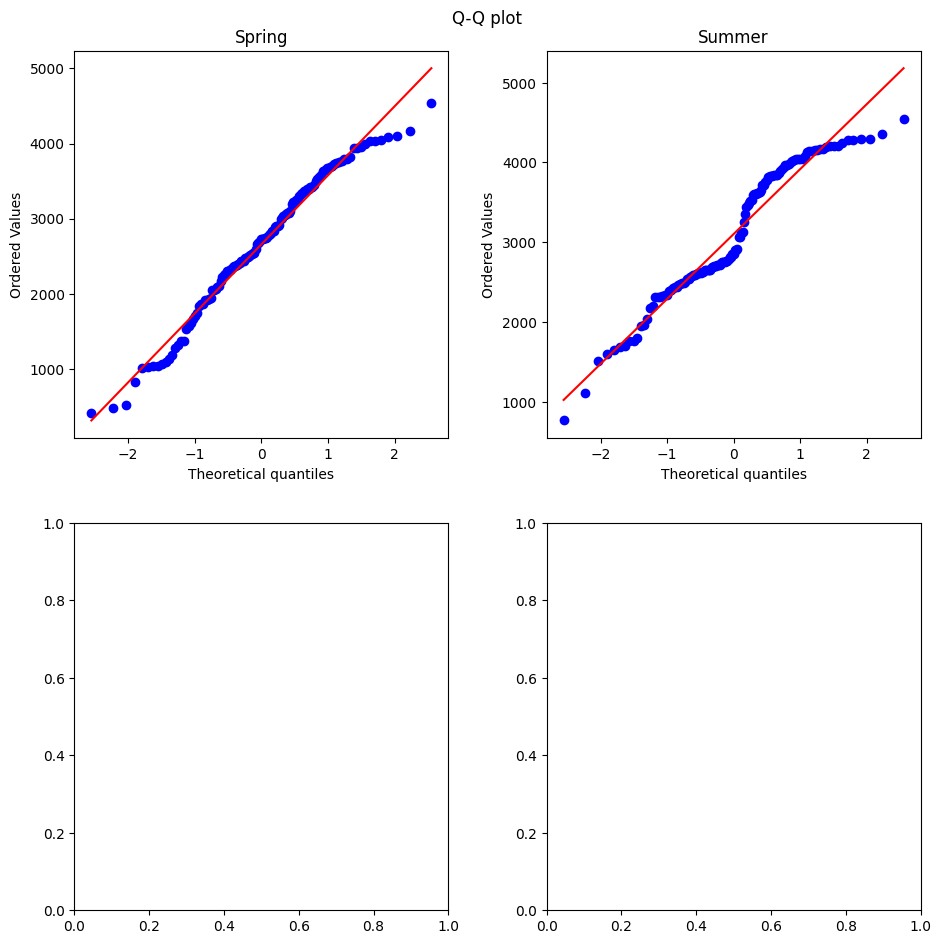

In [126]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
fig.tight_layout(pad=4)
fig.suptitle('Q-Q plot')

stats.probplot(data_spring_eve_workday['cnt'], dist="norm", plot=axs[0,0])
axs[0,0].title.set_text("Spring")
stats.probplot(data_summer_eve_workday['cnt'], dist="norm", plot=axs[0,1])
axs[0,1].title.set_text("Summer")

In [109]:
a = np.arange(9)
a
adf = pd.DataFrame(a)
adf.std()

0    2.738613
dtype: float64

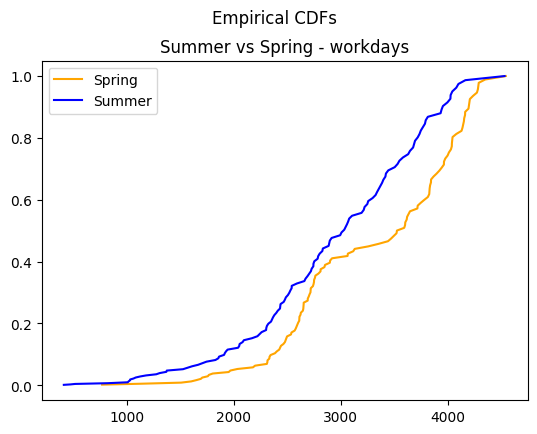

In [110]:
# Plot cdfs of found Gaussians:
fig, axs = plt.subplots(1)
fig.tight_layout(pad=4)
fig.suptitle('Empirical CDFs')

# Calculate Spring CDF
sorted_spring_data = data_spring_eve_workday.sort_values(by=['cnt'])
ecdf_spring_eve_workday = np.zeros(sorted_spring_data.shape[0])
for i, day in enumerate(sorted_spring_data['cnt']):
    ecdf_spring_eve_workday[i] = empircal_cdf(day, sorted_spring_data, 'cnt', 'cnt')

# Calculate Summer CDF
sorted_summer_data = data_summer_eve_workday.sort_values(by=['cnt'])
ecdf_summer_eve_workday = np.zeros(sorted_summer_data.shape[0])
for i, day in enumerate(sorted_summer_data['cnt']):
    ecdf_summer_eve_workday[i] = empircal_cdf(day, sorted_summer_data, 'cnt', 'cnt')

# Plot Spring vs Summer cdf
axs.plot(sorted_summer_data['cnt'], ecdf_summer_eve_workday, color = 'orange', label='Spring')
axs.plot(sorted_spring_data['cnt'], ecdf_spring_eve_workday, color = 'blue', label='Summer')
axs.title.set_text("Summer vs Spring - workdays")
axs.legend()